# Dynamics of Specialization

In this example, we will implement  2-module modular architectures from https://arxiv.org/abs/2106.02626

We examine 5 levels of structural modularity $Q$, by changing the amount of interconnection $p$ present between module, as well as 3 different module sizes $n$

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from tqdm.notebook import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

## Data

### Generate

We generate double-MNIST data, suited for a 2-module modular architecture

In [3]:
from dynspec.datasets import get_datasets
from dynspec.data_process import process_data
from dynspec.tasks import get_task_target
from dynspec.decision import get_decision

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
n_modules = 2
n_classes_per_digit = 4
n_classes = n_classes_per_digit * n_modules
nb_steps = 2

data_config = {
    # ------ Change if needed------
    "batch_size": 256,
    "input_size": 28,
    "use_cuda": use_cuda,
    "data_type": "double_digits",
    "n_digits": n_modules,
    "n_classes": n_classes,
    "n_classes_per_digit": n_classes_per_digit,
    "nb_steps": nb_steps,
    # cov ratio : controls the probabilty of seeing D1 == D2, default = 1 (chance probability)
    "cov_ratio": 1,
    # noise ratio : controls the ammount of noise added to the input , default = 0.4
    "noise_ratio": 0.2,
    # random start : add stochasticity by having input start at random times from pure noise, default = False
    "random_start": False,
    "fix_asym": True,
    # --------------------------
}

In [6]:
all_data = get_datasets("../data/", data_config)
datasets, loaders = all_data[data_config["data_type"]]
len(datasets[0])

12288

### Plot

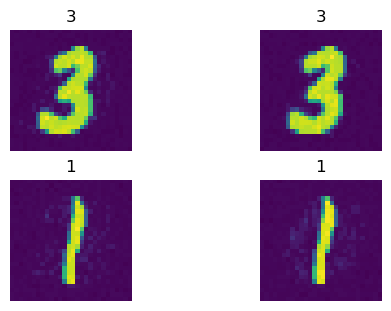

In [7]:
data, target = next(iter(loaders[0]))

temporal_data, _ = process_data(data, data_config)
temporal_data = torch.stack(
    temporal_data.split(temporal_data.shape[-1] // n_modules, -1), 1
)

fig, axs = plt.subplots(
    n_modules, temporal_data.shape[0], constrained_layout=True, figsize=(5, 3)
)
for t_data, t_axs in zip(temporal_data, axs.T):
    for d, ax, t in zip(t_data, t_axs, target[0].cpu().numpy()):
        ax.imshow(d[0].cpu().numpy().reshape(28, 28))
        ax.axis("off")
        ax.set_title(t)

## Init Models

Initialization of models with varying ammount of structural modularity

In [11]:
from dynspec.models import Community, init_model
from torch.nn import RNN, GRU, RNNCell, GRUCell
from dynspec.plotting import plot_model_masks
import pandas as pd
from dynspec.training import train_community, get_acc, get_loss
from dynspec.experiment import Experiment

In [12]:
# feel free to try other tasks, such as 'sum' or 'bitxor'
task = "parity-digits"
# task = 'sum'
# task = "bitxor"

modules_config = {
    "n_modules": 2,
    "hidden_size": None,  # will be changed later
    "n_layers": 1,
    "dropout": 0.0,
    "cell_type": str(RNN),
}
connections_config = {"sparsity": None, "binary" : True}  # Will be changed later
input_config = {"input_size": data_config["input_size"] ** 2, "common_input": False}
optim_config = {"lr": 1e-3, "weight_decay": 1e-5, "gamma":0.95}
readout_config = {"common_readout": False}
decision = ["last", "max"]
training_config = {"n_epochs": 100, "task": task}

default_config = {
    "modules": modules_config,
    "connections": connections_config,
    "input": input_config,
    "readout": readout_config,
    "data": data_config,
    "decision": decision,
    "training": training_config,
    "optim": optim_config,
}

In [13]:
# We look at networks of 1 or 3 different sizes and 5 sparsity levels. The following parameters come with pre-loaded examples
n_hiddens = [10]
# n_hiddens = [10, 25, 50]
# Negative values for the sparsity field directly specify number of connections (irrelevant of the hidden size) : eg -1 means exactly 1 connection
# sparsities = [-1, 1e-2, 1e-1, 0.5, 1.0]
sparsities = [-1]
varying_params = {"hidden_size": n_hiddens, "sparsity": sparsities}

In [14]:
# Save yourself some training time by pre-loading the results, or check out training by yourself. On a gpu, it should take about 5 minutes per model (for 30 epochs)
experiment = Experiment(
    default_config, varying_params, load_save=False, n_tests=1, device=device
)

Creating new Experiment


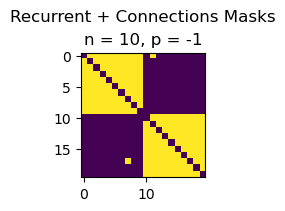

In [16]:
# plot the reccurent connections of the models, this changes depending on the sparsity of intereconnections
plot_model_masks(experiment, plot_input=False)

## Training

In [31]:
if not experiment.loaded:
    experiment.run(loaders, save=True)

  0%|          | 0/1 [00:00<?, ?it/s]

/home/gb21/.conda/envs/dynspec/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


In [23]:
from dynspec.plotting import plot_model_pair_behavior

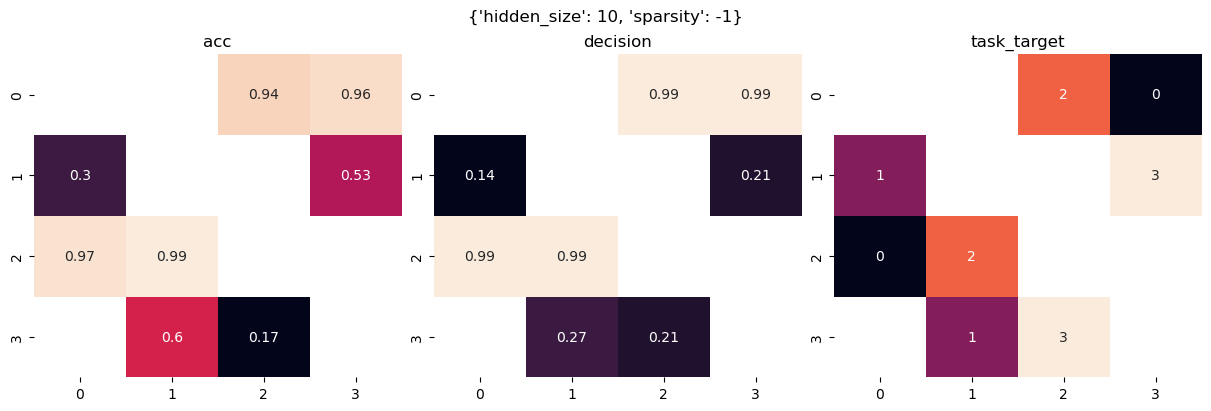

In [24]:
plot_model_pair_behavior(experiment, loaders)

In [46]:
data, target = next(iter(loaders[1]))
model = experiment.models[0]

# a dict to store the activations
activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

h1 = model.core.parametrizations["weight_ih_l0"][0].register_forward_hook(getActivation("relu"))

In [43]:

data, _ = process_data(data, default_config["data"])
data, target = data.to(device), target.to(device)
t_target = get_task_target(target, task, n_classes=n_classes)
out, all_states = model(data)
out, deciding_ag = get_decision(out, *decision)
acc, all_accs = get_acc(out, t_target, decision[1] == "both")


In [45]:
activation

{'Masked_weight': tensor([[ 0.0983,  0.0008,  0.0930,  ...,  0.0000, -0.0000,  0.0000],
         [-0.0171, -0.1926,  0.0902,  ..., -0.0000,  0.0000,  0.0000],
         [-0.0754, -0.0386,  0.1354,  ..., -0.0000,  0.0000, -0.0000],
         ...,
         [ 0.0000, -0.0000, -0.0000,  ...,  0.2187,  0.1470,  0.0698],
         [ 0.0000, -0.0000, -0.0000,  ...,  0.1862,  0.1480, -0.0217],
         [-0.0000,  0.0000,  0.0000,  ..., -0.1137,  0.0244,  0.1634]],
        device='cuda:0'),
 'relu': tensor([[ 0.0983,  0.0008,  0.0930,  ...,  0.0000, -0.0000,  0.0000],
         [-0.0171, -0.1926,  0.0902,  ..., -0.0000,  0.0000,  0.0000],
         [-0.0754, -0.0386,  0.1354,  ..., -0.0000,  0.0000, -0.0000],
         ...,
         [ 0.0000, -0.0000, -0.0000,  ...,  0.2187,  0.1470,  0.0698],
         [ 0.0000, -0.0000, -0.0000,  ...,  0.1862,  0.1480, -0.0217],
         [-0.0000,  0.0000,  0.0000,  ..., -0.1137,  0.0244,  0.1634]],
        device='cuda:0')}

array(0.0078125, dtype=float32)

In [17]:
raise KeyboardInterrupt

KeyboardInterrupt: 

### Results

In [ ]:
from dynspec.plotting import plot_accs

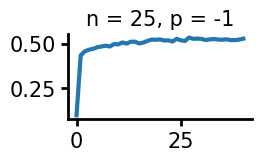

In [ ]:
plot_accs(experiment)

## Metrics

In [ ]:
from dynspec.plotting import plot_metric_results

### Retraining

In [ ]:
if (not experiment.loaded) or (experiment.retrained_models is None):
    experiment.compute_retraining(loaders, save=True)

  0%|          | 0/1 [00:00<?, ?it/s]

results/pre-loaded-examples/52a28e6e110e9e8911ccde086c4c1150e8dff22e
Results saved


### Correlations

In [ ]:
from dynspec.correlations import fixed_information_data

#### Plot modified data for correlations
The idea here is to look at autocorrelation of hidden states, when only one digit is varying and the other is fixed.

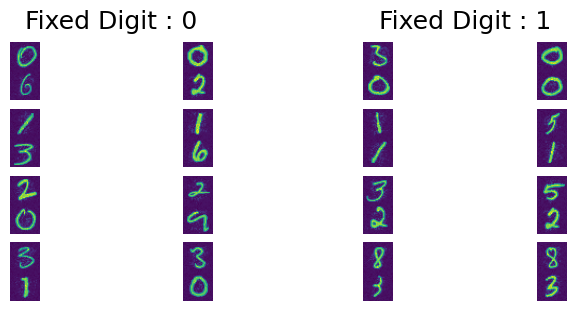

In [ ]:
data, target = next(iter(loaders[0]))
data = process_data(data, data_config)[0]
fig = plt.figure(figsize=(7, 3), constrained_layout=True)
subfigs = fig.subfigures(1, 2)
for fixed, subfig in enumerate(subfigs):
    f_datas = fixed_information_data(data, target, fixed=fixed)
    axs = subfig.subplots(len(f_datas[:4]), nb_steps)
    subfig.suptitle(f"Fixed Digit : {fixed}")
    for axs_t, f_d in zip(axs, f_datas):
        [
            ax.imshow(d[i].reshape(2 * 28, 28))
            for i, (ax, d) in enumerate(zip(axs_t, f_d))
        ]
        [ax.axis("off") for ax in axs_t]

In [ ]:
if (not experiment.loaded) or (not "correlations" in experiment.results.columns):
    experiment.compute_correlations(loaders, save=True)

  0%|          | 0/1 [00:00<?, ?it/s]

results/pre-loaded-examples/52a28e6e110e9e8911ccde086c4c1150e8dff22e
Results saved


### Ablations

In [ ]:
if (not experiment.loaded) or (not "ablations" in experiment.results.columns):
    experiment.compute_ablations(loaders, save=True)

Ablations Metric:   0%|          | 0/1 [00:00<?, ?it/s]

results/pre-loaded-examples/52a28e6e110e9e8911ccde086c4c1150e8dff22e
Results saved


## Plot Results

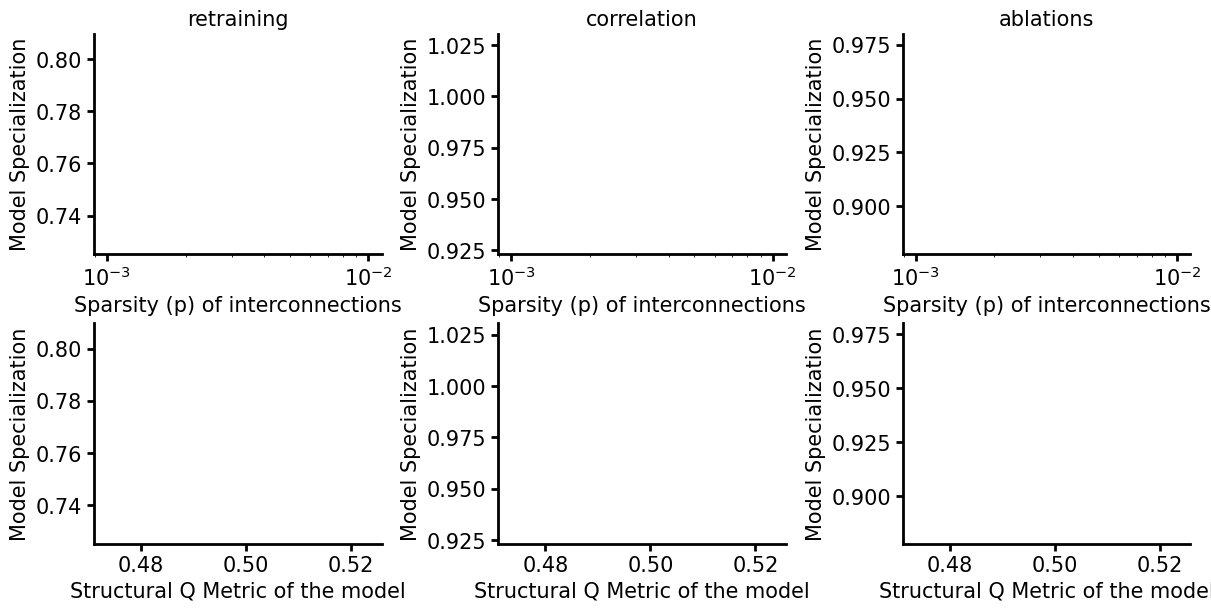

In [ ]:
metric_data = plot_metric_results(experiment)

In [ ]:
from dynspec.correlations import get_correlation, randperm_no_fixed
from cka.CKA import CKA

cka_fn = CKA().linear_CKA

In [ ]:
model, data = experiment.models[0].cpu(), f_d
states = [model(data)[1] for data in f_datas]
agent_states = [
    [ag_s.cpu().data.numpy() for ag_s in s.split(model.hidden_size, -1)] for s in states
]
agent_states = list(zip(*agent_states))
min_data_size = min([data.shape[1] for data in f_datas])

In [ ]:
states[0].shape

torch.Size([2, 33, 50])

In [ ]:
mean_ckas = [
    np.mean(
        [
            cka_fn(s1[1, :min_data_size], s2[1, :min_data_size])
            for s1, s2 in product(s, repeat=2)
            if not s1 is s2
        ]
    )
    for s in agent_states
]

In [ ]:
mean_ckas

[0.32547985134536356, 0.340256457119719]

In [ ]:
np.mean([cka_fn(agent_states_0[-1, :min_data_size], agent_states_1[-1, :min_data_size]) for agent_states_0, agent_states_1 in product(agent_states

0.41079727169887253

In [ ]:
min_data_size

25

In [ ]:
agent_states = states.split(model.hidden_size, -1)
agent_states = [ag_s.cpu().data.numpy() for ag_s in agent_states]
perm = randperm_no_fixed(agent_states[0].shape[1])
cka_fn = CKA().linear_CKA
v_cka = lambda s1, s2: np.stack([cka_fn(x, y) for x, y in zip(s1, s2)])
corr = np.stack([v_cka(ag_s, ag_s[:, perm]) for ag_s in agent_states], 1)
corr

In [ ]:
v_cka(agent_states[0], agent_states[0][:, perm])

array([0.23909854, 0.20674119])

In [ ]:
cka_fn(agent_states[0][-1], agent_states[0][-1, perm])

0.1551839642065789

In [ ]:
agent_states[0][:, perm].shape

(2, 29, 25)

In [ ]:
get_correlation(experiment.models[0].cpu(), f_d).shape

(2, 2, 29)

In [ ]:
get_correlation(experiment.models[0].cpu(), f_d, corr_func="cka")

array([[0.24482417, 0.21459026],
       [0.163896  , 0.19881769]])

In [ ]:
experiment.models

[Community(
   (core): ParametrizedRNN(
     1568, 50, bias=False
     (parametrizations): ModuleDict(
       (weight_ih_l0): ParametrizationList(
         (0): Masked_weight()
       )
       (weight_hh_l0): ParametrizationList(
         (0): Masked_weight()
         (1): Scaled_mask_weight()
       )
     )
   )
   (readout): Readout(
     (layers): ModuleList(
       (0-1): 2 x ParametrizedLinear(
         in_features=50, out_features=20, bias=True
         (parametrizations): ModuleDict(
           (weight): ParametrizationList(
             (0): Masked_weight()
           )
         )
       )
     )
   )
 ),
 Community(
   (core): ParametrizedRNN(
     1568, 50, bias=False
     (parametrizations): ModuleDict(
       (weight_ih_l0): ParametrizationList(
         (0): Masked_weight()
       )
       (weight_hh_l0): ParametrizationList(
         (0): Masked_weight()
         (1): Scaled_mask_weight()
       )
     )
   )
   (readout): Readout(
     (layers): ModuleList(
       (0-1)

### Random Timings

In [ ]:
from dynspec.plotting import plot_random_timings
from dynspec.retraining import diff_metric, metric_norm_acc

In [ ]:
experiment.compute_random_timing(loaders)

  0%|          | 0/5 [00:00<?, ?it/s]

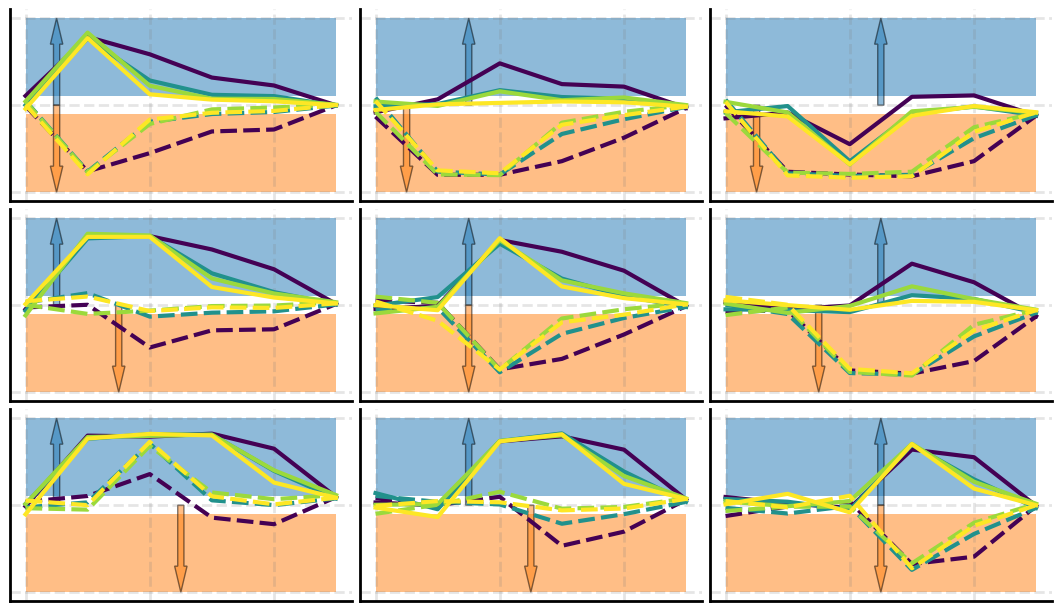

In [ ]:
plot_data = plot_random_timings(experiment)